In [0]:
%tensorflow_version 1.x
import os
import h5py
import random
import datetime
import numpy as np
import pandas as pd
from google.colab import drive
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.applications import VGG19
from keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import TensorBoard
from keras.models import Model, Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Dropout, Input, concatenate
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

TensorFlow is already loaded. Please restart the runtime to change versions.


In [0]:
drive.mount('/content/drive')
os.chdir('/content/drive/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Read the dataset, seperate the training and testing dataset

In [0]:
f =  h5py.File('My Drive/Stethoscope/13A_data.hdf5', "r+")

specs = np.array(f["specs"]).astype("float32")
sonotypes = np.array(f["sonotypes"])
times = np.array(f["times"]).astype("float32")
freqs = np.array(f["freqs"]).astype("float32")

f.close()

In [0]:
# append x_times an x_freqs to be auxiliary_input
aux_input = np.append(x_times,x_freqs, axis = 1)

print(aux_input.shape)
print(aux_input[10])

(1467, 4)
[25568.    25569.885  2555.7    6464.3  ]


In [0]:
x_train, x_test, y_train, y_test, aux_train, aux_test = train_test_split(specs, sonotypes, aux_input,test_size=0.1)


print(len(x_train))
print(len(x_test))

1320
147


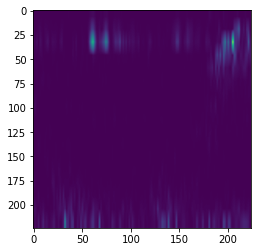

In [0]:
plt.imshow(x_train[100][:,:,0])
plt.show()

#To Categorical

In [0]:
# Convert labels to a categorical array
# currently 492 classes for trainning set and 490 tests for test class
cat_y_test = to_categorical(y_test, num_classes = 500)
cat_y_train = to_categorical(y_train, num_classes = 500)

#Model


In [0]:
config = dict(
    dropout = 0.55,
    hidden = 1024,
    learn_rate = 0.00001,
    epochs = 30,
    )

In [0]:
def build_finetune_model(base_model, dropouts, fc_layers, num_classes):
    #for layer in base_model.layers:
    #    layer.trainable = False

    x = base_model.output
    x = Flatten()(x)

    # add input layer
    auxiliary_input = Input(shape=(4,), name='aux_input')
    x = concatenate([x, auxiliary_input])

    for fc, drop in zip(fc_layers, dropouts):
        x = Dense(fc, activation='relu')(x) 
        x = Dropout(drop)(x)

    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=[base_model.input,auxiliary_input], outputs=predictions)
    # finetune_model = Model(inputs=base_model.input, outputs=predictions)

    return finetune_model

model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
model = build_finetune_model(model, 
                             [config["dropout"], config["dropout"]], 
                             [config["hidden"], config["hidden"]], 
                             cat_y_test.shape[1])

In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

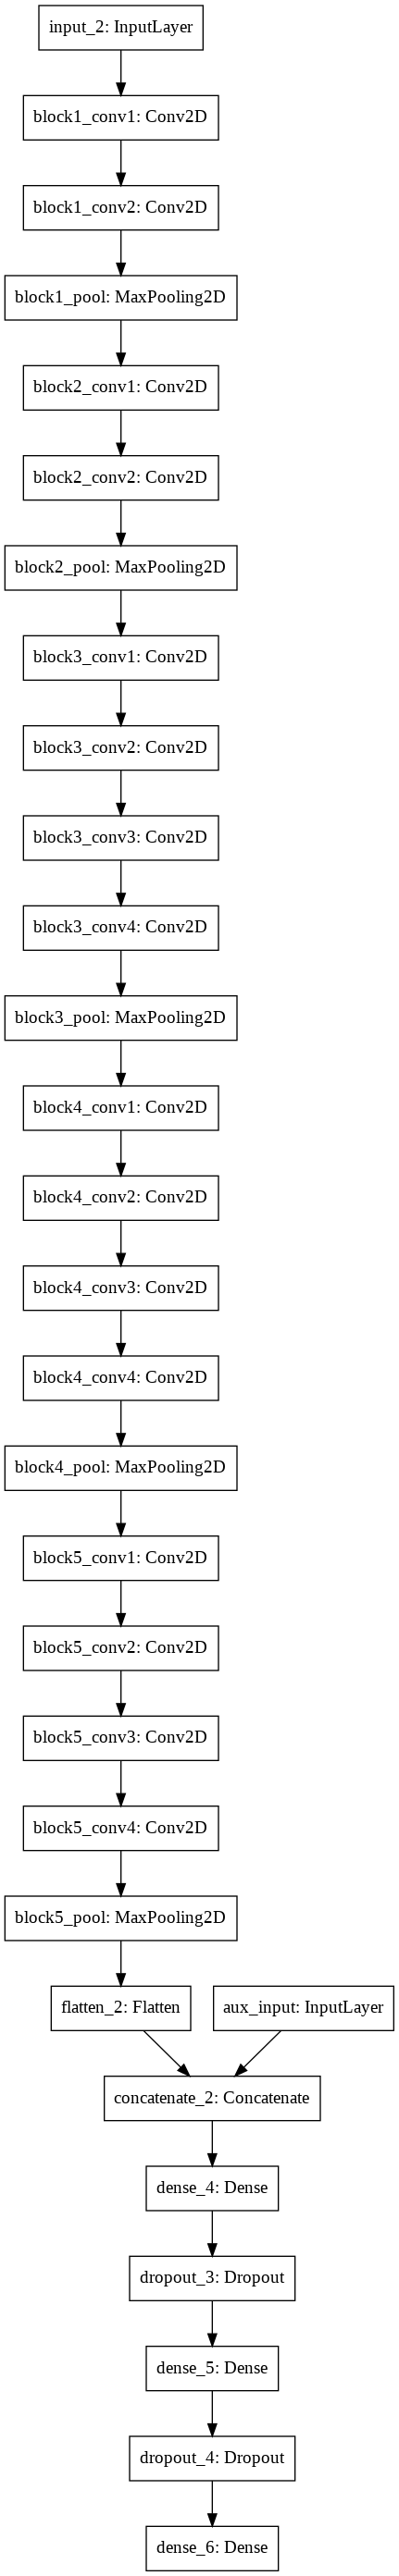

In [0]:
plot_model(model,to_file = 'My Drive/Stethoscope/model.png')

#Training

In [0]:
filepath = 'My Drive/Stethoscope/model.hdf5'

earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

opt = Adam(lr=config["learn_rate"])
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x=[x_train, aux_train], y=cat_y_train, validation_data=([x_test, aux_test], cat_y_test), epochs=config["epochs"], callbacks=[earlystop, checkpoint])
# history = model.fit(x=x_train, y=cat_y_train, validation_data=(x_test, cat_y_test), epochs=config["epochs"])

ValueError: ignored

#Model Performance

Text(0.5, 1.0, 'Accuracy Curves')

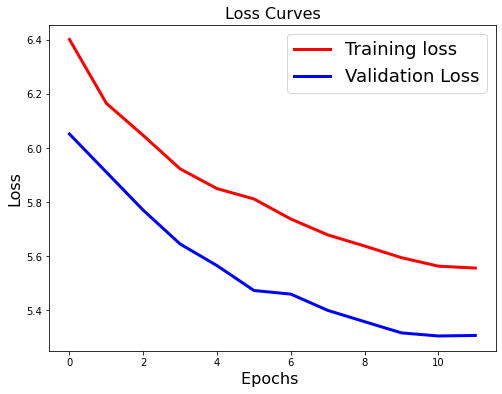

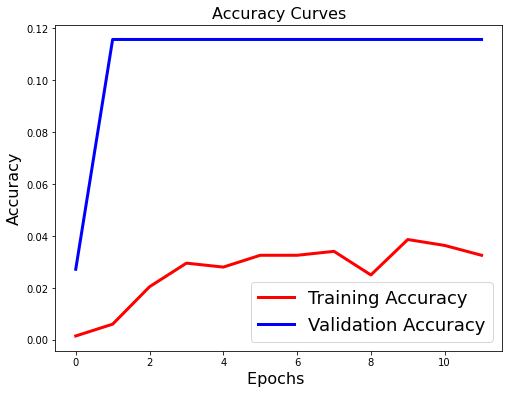

In [0]:
# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)


Text(0.5, 1.0, '\nPrediction: [25]\nActual: [95]\nConfidence: 4.22%')

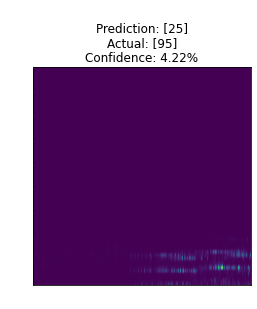

In [0]:
# prediction
%matplotlib inline
randIdx = random.randint(0,x_test.shape[0])
test_img = x_test[randIdx]
confidence = model.predict(np.reshape(test_img,(1,224,224,3)))
c  = float(str(confidence[0][np.argmax(confidence)])[:6]);

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
img = plt.imshow(test_img[:,:,1])
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
title = ('\nPrediction: ' + str([np.argmax(confidence)]) + 
          '\nActual: ' + str([np.argmax(cat_y_test[randIdx])]) +
          '\nConfidence: ' +'{:.2%}'.format(c))
plt.title(title)
